In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path = '../Neuro_dataset/'
path_alz = path + os.listdir(path)[1]
path_nor = path + os.listdir(path)[2]

In [4]:
files_alz = os.listdir(path_alz)
files_nor = os.listdir(path_nor)
d = loadmat(path_alz + '/' + files_alz[0])
d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
X_aal = d['tc_rest_aal']
X_pow = d['tc_rest_power']

for i in range(1, len(files_alz)):
    d = loadmat(path_alz + '/' + files_alz[i])
    d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
    d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
    X_aal = np.vstack([X_aal, d['tc_rest_aal']])
    X_pow = np.vstack([X_pow, d['tc_rest_power']])

for i in range(len(files_nor)):
    d = loadmat(path_nor + '/' + files_nor[i])
    d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
    d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
    X_aal = np.vstack([X_aal, d['tc_rest_aal']])
    X_pow = np.vstack([X_pow, d['tc_rest_power']])

In [5]:
y = [1 for i in range(34)]
y.extend([0 for i in range(47)])
y = np.array(y).reshape((81, 1))
y.shape

(81, 1)

In [6]:
X_aal.shape, X_pow.shape

((81, 140, 116), (81, 140, 264))

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pow, y, test_size = 0.2)
a = X_train.shape[1]
b = X_train.shape[2]
print(X_train.shape, X_test.shape)

(64, 140, 264) (17, 140, 264)


In [105]:
X_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_train.shape, X_test.shape)

(64, 140, 264) (17, 140, 264)


In [106]:
X_train.shape[1:]

(140, 264)

In [107]:
lam = tf.keras.regularizers.l2(l=0.1)
init = tf.initializers.he_normal()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.LSTM(32, kernel_regularizer=lam, kernel_initializer=init, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(16, kernel_regularizer=lam, kernel_initializer=init,),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=lam, kernel_initializer=init),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 140, 32)           38016     
_________________________________________________________________
dropout_21 (Dropout)         (None, 140, 32)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_22 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_23 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [108]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [109]:
history = model.fit(X_train, y_train, batch_size=4, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
16/16 [==============================] - 4s 73ms/step - loss: 39.8391 - accuracy: 0.6655 - val_loss: 38.0269 - val_accuracy: 0.4706
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 37.4039 - accuracy: 0.6413 - val_loss: 35.7109 - val_accuracy: 0.4706
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 35.1262 - accuracy: 0.6011 - val_loss: 33.5407 - val_accuracy: 0.4706
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 32.9826 - accuracy: 0.5883 - val_loss: 31.5048 - val_accuracy: 0.4706
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 30.9798 - accuracy: 0.5932 - val_loss: 29.5950 - val_accuracy: 0.4706
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: 29.0972 - accuracy: 0.5261 - val_loss: 27.8039 - val_accuracy: 0.4706
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 27.3107 - accuracy: 0.6266 - val_loss: 26.1221 - val_accuracy:

In [110]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix
a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

Accuracy is: 58.82352941176471


Text(0.5, 1.0, "'aal'+'power' dataset")

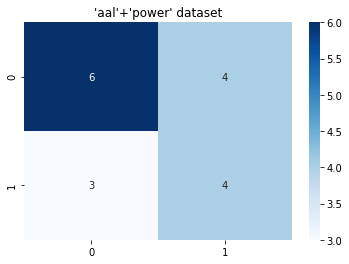

In [112]:
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g', cmap='Blues')
plt.title("'aal'+'power' dataset")

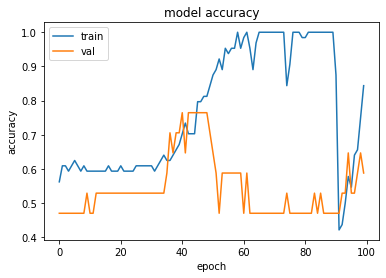

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

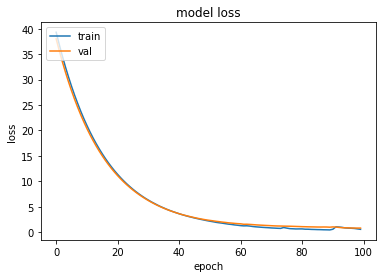

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()